In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from yahoofinancials import YahooFinancials

In [2]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date));

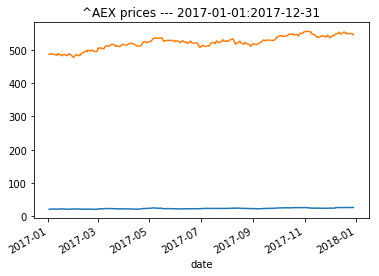

In [7]:
tickers=['ABN.AS', '^AEX']

for ticker in tickers:
    download_csv_data(ticker=ticker, 
                      start_date='2017-01-01', 
                      end_date='2017-12-31', 
                      freq='daily', 
                      path='european/daily/'+ticker.strip(' .^')+'.csv')
    df=None

In [9]:
!zipline bundles


csvdir <no ingestions>
quandl <no ingestions>
quantopian-quandl <no ingestions>


In [13]:
from zipline.data import bundles
from zipline.data.bundles.csvdir import csvdir_equities
import os

start_session = pd.Timestamp('2017-01-02', tz='utc')
end_session = pd.Timestamp('2017-12-29', tz='utc')

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(),'european')
# Create an ingest function 
ingest_func = csvdir_equities(['daily'], os.environ['ZIPLINE_ROOT'])

# Register the data bundle and its ingest function
bundles.register('eu_stocks', ingest_func, 
                 calendar_name='XAMS',  # Euronext Amsterdam
                start_session=start_session,
                end_session=end_session);

/Users/cnakhare/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Overwriting bundle with name 'eu_stocks'
  app.launch_new_instance()


In [14]:
bundles.ingest('eu_stocks')


 | ABN.AS: sid 0
 | AEX: sid 1


In [37]:
bundle_data = bundles.load('eu_stocks')

In [38]:
%%zipline --start 2017-1-2 --end 2017-12-29 --capital-base 250 --bundle eu_stocks -o buy_and_hold.pkl --trading-calendar XAMS


UsageError: Cell magic `%%zipline` not found.


In [34]:
from zipline.api import order, symbol, record, set_benchmark
import zipline
from zipline.algorithm import TradingAlgorithm

# parameters
selected_stock = 'ABN.AS'
n_stocks_to_buy = 10

def initialize(context):
    set_benchmark(symbol('AEX'))
    context.asset = symbol('ABN.AS')
    context.has_ordered = False  

def handle_data(context, data):
    # record price for further inspection
    record(price=data.current(symbol(selected_stock), 'price'))
    
    # trading logic
    if not context.has_ordered:
        # placing order, negative number for sale/short
        order(symbol(selected_stock), n_stocks_to_buy)
        # setting up a flag for holding a position
        context.has_ordered = True

In [30]:
perf = zipline.run_algorithm(start=start_session,
                      end=end_session,
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data,
                      bundle='eu_stocks')
perf

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [31]:
type(bundle_data)

zipline.data.bundles.core.BundleData

In [36]:
algo_obj= TradingAlgorithm(start=start_session,
                      end=end_session,
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)